In [1]:
import torch
import os
import numpy as np
import gymnasium as gym

print("current path: ", (os.getcwd()))
print("Done importing!")

from four_room.env import FourRoomsEnv

gym.register('MiniGrid-FourRooms-v1', FourRoomsEnv)


pygame 2.4.0 (SDL 2.26.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
current path:  /home/felix/stuff/uni/thesis/fix_her/experiments
Done importing!


## Todos:
  1. actually uses vecenv ✅
  1. get experiment with base dqn to work ✅
  1. visualisation of results ✅
  1. implement Random noise distillation to check what points are _rare_
  1. alter the dqn to start from random spot (not wall), maybe complicated because of vecenv
  1. get experiments to run with altered dqn

## Questions to ask: 
  1. ask about dummyvecenv or subprocenv
  1. ask about double dqn
  1. should RND be trained on whole buffer or just the ones we sampled or just the ones we sampled an kept? 
  1. buffer size 500k fr? isnt that the whole experience
  1. learning_starts? default or 0?

In [2]:
## Creating Environments 2##
import dill
from four_room.env import FourRoomsEnv
from four_room.wrappers import gym_wrapper

from stable_baselines3.common.vec_env import SubprocVecEnv, VecFrameStack, DummyVecEnv


with open('./four_room/configs/fourrooms_train_config.pl', 'rb') as file:
    train_config = dill.load(file)

with open('./four_room/configs/fourrooms_test_0_config.pl', 'rb') as file:
    test_0_config = dill.load(file)

with open('./four_room/configs/fourrooms_test_100_config.pl', 'rb') as file:
    test_100_config = dill.load(file)

def make_env_fn(config, seed: int= 0, rank: int = 0):
    def _init():
        env = gym_wrapper(gym.make('MiniGrid-FourRooms-v1', 
                    agent_pos=config['agent positions'], 
                    goal_pos=config['goal positions'], 
                    doors_pos=config['topologies'], 
                    agent_dir=config['agent directions']))
        env.reset(seed=seed+rank)
        return env
    return _init

#######  

num_envs=8

env=make_env_fn(train_config)()

train_env = DummyVecEnv([make_env_fn(train_config, seed=0, rank=i) for i in range(num_envs)])

tr_ev_env = DummyVecEnv([make_env_fn(train_config, seed=0, rank=i) for i in range(num_envs)])
test_0_env = DummyVecEnv([make_env_fn(test_0_config, seed=0, rank=i) for i in range(num_envs)])
test_100_env = DummyVecEnv([make_env_fn(test_100_config, seed=0, rank=i) for i in range(num_envs)])


In [3]:
### Creating Agents ###

## Baseline 
from stable_baselines3.dqn import CnnPolicy
from stable_baselines3 import DQN, tpDQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn


lr_schedule = lambda x: 0.00009*x+0.00001

class Baseline_CNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 512):
        super(Baseline_CNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, padding_mode='circular'),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

baseline_policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[512,256,128], 
                              features_extractor_class=Baseline_CNN, features_extractor_kwargs={'features_dim': 512},
                              optimizer_class=torch.optim.Adam, 
                              normalize_images=False)

baseline_model = DQN('CnnPolicy', train_env, buffer_size=500000, batch_size=256, gamma=0.99, 
                     gradient_steps=1, train_freq=(10, 'step'), target_update_interval=10, tau=0.01,
                     exploration_initial_eps=1.0, exploration_final_eps=0.01, max_grad_norm=1.0, learning_rate=lr_schedule,
                     verbose=1, tensorboard_log="./four_room/tensorboard/", policy_kwargs=baseline_policy_kwargs ,device='cuda')

tp_model = tpDQN('CnnPolicy', train_env, buffer_size=500000, batch_size=256, gamma=0.99, 
                 
                    learning_starts=100, #idk what to set this at, for testing set at 100

                     gradient_steps=1, train_freq=(10, 'step'), target_update_interval=10, tau=0.01,
                     exploration_initial_eps=1.0, exploration_final_eps=0.01, max_grad_norm=1.0, learning_rate=lr_schedule,
                     verbose=1, tensorboard_log="./four_room/tensorboard/", policy_kwargs=baseline_policy_kwargs ,device='cuda')


Using cuda device
Using cuda device
----- RND initialization ---
Box(0, 1, (4, 9, 9), uint8)
(4, 9, 9)
----- RND initialization done ---


In [4]:
### Training Agents ###
from stable_baselines3.common.callbacks import EvalCallback
base_log = "./logs/log_baseline/"
os.makedirs(base_log, exist_ok=True)

eval_tr_callback = EvalCallback(tr_ev_env, log_path=base_log+"tr/", eval_freq=max(1000 // num_envs, 1),
                              n_eval_episodes=20, deterministic=True, render=False)

eval_0_callback = EvalCallback(test_0_env, log_path=base_log+"0/", eval_freq=max(1000 // num_envs, 1),
                              n_eval_episodes=20, deterministic=True, render=False)

eval_100_callback = EvalCallback(test_100_env, log_path=base_log+"100/", eval_freq=max(1000 // num_envs, 1),
                              n_eval_episodes=20, deterministic=True, render=False)

#total_timesteps = 500000 should be used, will use 200000 for testing
#baseline_model.learn(total_timesteps=500000, log_interval=10, callback=[eval_tr_callback,eval_0_callback,eval_100_callback])
tp_model.learn(total_timesteps=500000, log_interval=10, callback=[eval_tr_callback,eval_0_callback,eval_100_callback])

2024-01-06 16:01:29.080269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 16:01:29.634192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/felix/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-01-06 16:01:29.634271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/felix/.local/lib/python3.10/site-packages/cv2/../../lib64:


Logging to ./four_room/tensorboard/tpDQN_8
80 1000 False
160 1000 False
240 1000 False
320 1000 False
400 1000 False
480 1000 False
560 1000 False
640 1000 False
720 1000 False
800 1000 False
880 1000 False
960 1000 False


/home/felix/stuff/uni/thesis/fix_her/experiments/stable-baselines3-thesis/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 100      |
|    mean_reward      | 0        |
| rollout/            |          |
|    exploration_rate | 0.98     |
| time/               |          |
|    total_timesteps  | 1000     |
----------------------------------
New best mean reward!
Eval num_timesteps=1000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | 0        |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=1000, episode_reward=0.00 +/- 0.00
Episode length: 100.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 100      |
|    mean_reward     | 0        |
| time/  

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)

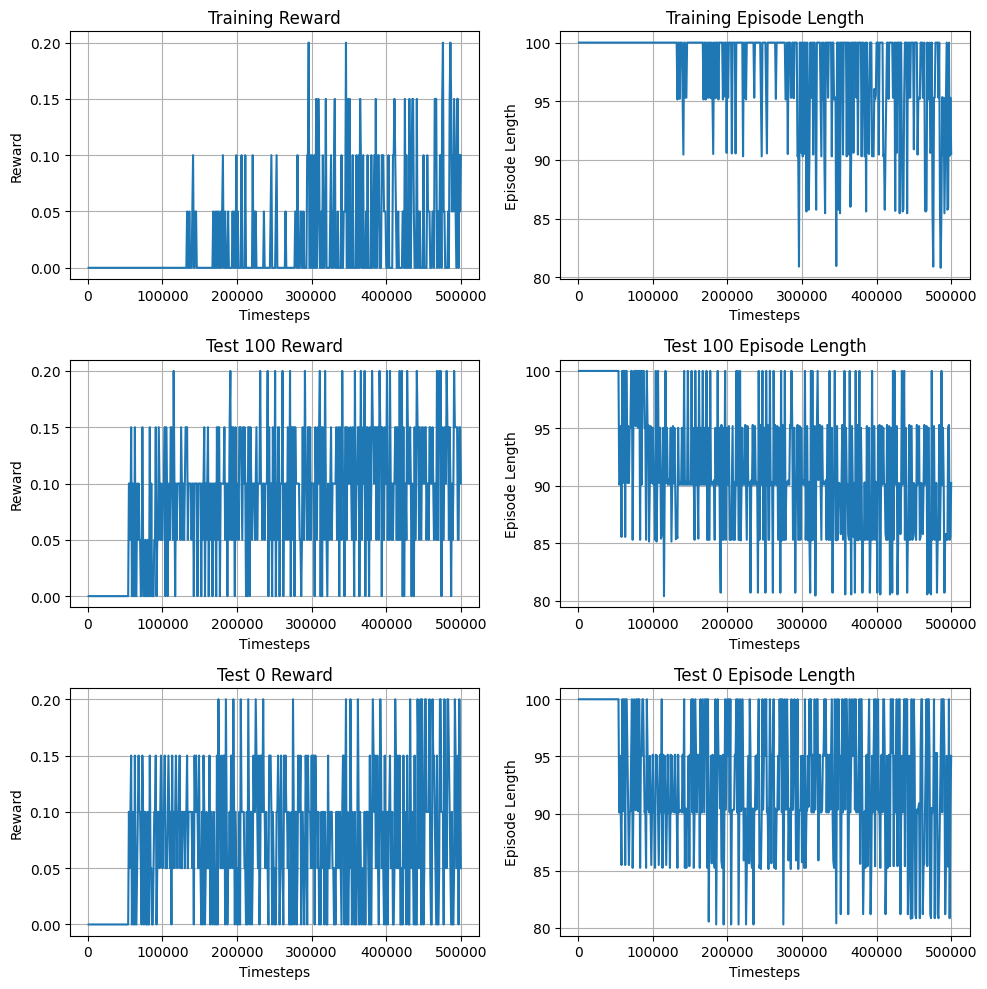

In [ ]:
### Making Results pretty

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results={}

for env in ['tr', '0', '100']:
    tmp=np.load(base_log+env+'/evaluations.npz')
    results[env]={}
    results[env]['results']=np.mean(tmp['results'],axis=1)
    results[env]['ep_lengths']=np.mean(tmp['ep_lengths'],axis=1)
    results[env]['timesteps']=tmp['timesteps']


def plot_reward(ax,dt, title):
    sns.lineplot(x=dt['timesteps'], y=dt['results'], ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Reward')
    ax.set_xlabel('Timesteps')
    ax.grid(True)

def plot_episode_length(ax,dt, title):
    sns.lineplot(x=dt['timesteps'], y=dt['ep_lengths'], ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Episode Length')
    ax.set_xlabel('Timesteps')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(10,10))
plot_reward(ax[0,0],results['tr'], 'Training Reward')
plot_episode_length(ax[0,1],results['tr'], 'Training Episode Length')

plot_reward(ax[1,0],results['100'], 'Test 100 Reward')
plot_episode_length(ax[1,1],results['100'], 'Test 100 Episode Length')

plot_reward(ax[2,0],results['0'], 'Test 0 Reward')
plot_episode_length(ax[2,1],results['0'], 'Test 0 Episode Length')

plt.tight_layout()